In [1]:
#%matplotlib widget

Import libraries:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ipywidgets import interact,IntSlider
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

Import hdf5 file and save arrays to local variables:

In [3]:
#!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

In [4]:
filepath = 'content/banyuls_data/fish1_different_directions.hdf5'
file=h5py.File(filepath, 'r')

In [5]:
dict(file.attrs)

{'age': 21, 'date': '2023-01-24', 'line': 'HUC'}

In [6]:
def printname(name):
    print(name)

file.visit(printname)

brain
brain/coordinates
brain/fluorescence
brain/times
stimulus
stimulus/direction
stimulus/speed
stimulus/times
tail
tail/coordinates
tail/deflection
tail/deflection_mean
tail/deflection_std
tail/times


In [7]:
def create_variable(name,node):
    if isinstance(node,h5py.Dataset):
        globals()[name.replace('/','_')]=node[...]

file.visititems(create_variable)

### Correlation between brain activity and tail movement:

Define some functions:

In [8]:
#signal_times must be linearly spaced
def convolve(signal,signal_times,output_times,t_decay=3.5,t_rise=0.1,window_width_time=60):
    dt=signal_times[1]-signal_times[0]
    tcirf=np.arange(0,int(window_width_time/dt))*dt #only consider points in a window of duration window_width_time, it must be much larger than the charactering time of the cirf
    if t_rise==0: #decaying exponential with decay time t_decay as a calcium impulse response function
        cirf=np.exp(-tcirf/t_decay) 
    else: #difference of rising and decaying exponentials with characteristic times t_decay and t_rise
        cirf=np.exp(-tcirf/t_decay)-np.exp(-tcirf/t_rise)
    signal_convolved=np.zeros(len(signal))
    for i in range(len(signal)):
        signal_convolved[i:i+len(cirf)]+=signal[i]*cirf[:len(signal_convolved[i:i+len(cirf)])]
    signal_convolved*=dt #integration timestep
    f_signal_convolved=interp1d(signal_times,signal_convolved,kind='linear',fill_value='extrapolate')
    signal_convolved_int=f_signal_convolved(output_times) #interpolate on the output_times array
    return signal_convolved_int

In [9]:
#signal_times must be linearly spaced
def interpolate(signal,signal_times,output_times,kind='linear'):
    f_signal=interp1d(signal_times,signal,kind=kind,fill_value='extrapolate')
    signal_int=f_signal(output_times) #interpolate on the output_times array
    return signal_int

In [10]:
def center(signal):
    return (signal-np.nanmean(signal))/np.nanstd(signal)

Plot signal for which we want to calculate the mutual information with the brain activity:

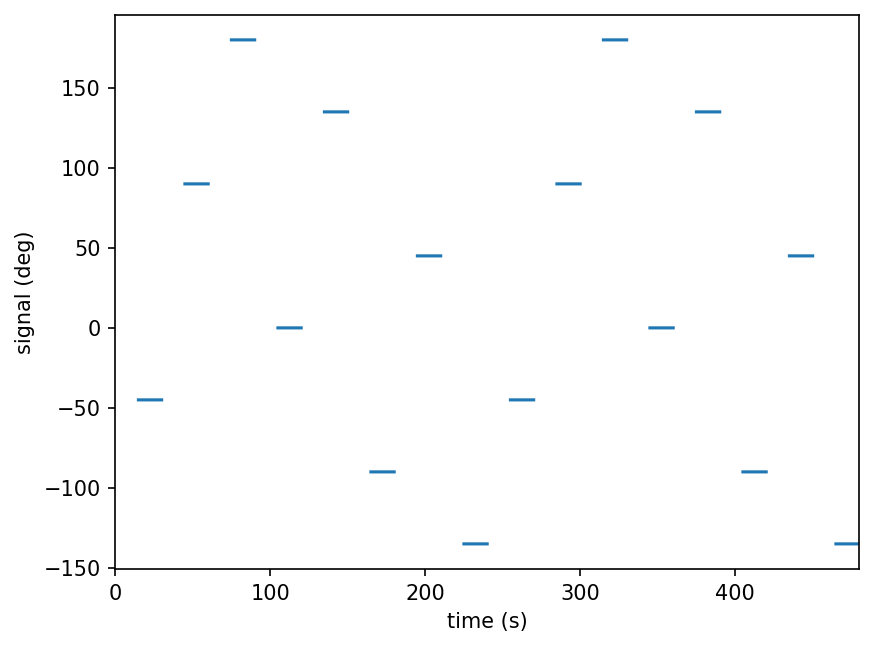

In [11]:
t1=0
t2=tail_times[-1]

fig,ax=plt.subplots(dpi=150)

ax.plot(stimulus_times,stimulus_direction)
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')

plt.show()

In [12]:
signal=interpolate(stimulus_direction,stimulus_times,brain_times)

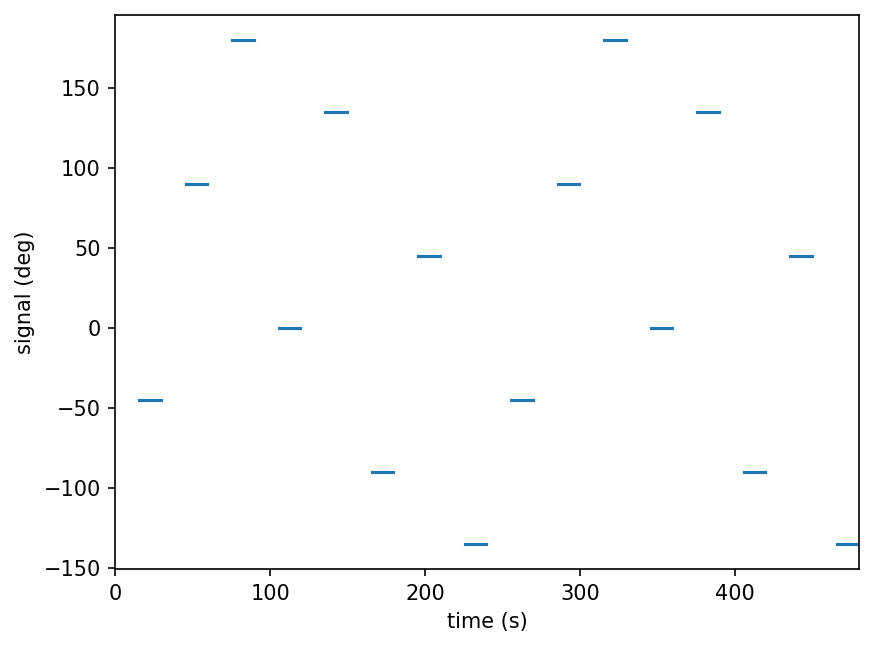

In [13]:
t1=0
t2=tail_times[-1]

fig,ax=plt.subplots(dpi=150)

ax.plot(brain_times,signal)
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')

plt.show()

In [14]:
signal_notnan=signal[~np.isnan(signal)]
brain_times_notnan=brain_times[~np.isnan(signal)]
brain_fluorescence_notnan=np.zeros((len(brain_fluorescence),len(signal_notnan)))
for i in range(len(brain_fluorescence)):
    brain_fluorescence_notnan[i]=brain_fluorescence[i][~np.isnan(signal)]

In [15]:
n_neighbors=3

In [16]:
%%time
mutual_info=np.zeros(len(brain_fluorescence))
X=signal_notnan.reshape(-1, 1)
for i in range(len(brain_fluorescence)):
    mutual_info[i]=mutual_info_regression(X,brain_fluorescence_notnan[i],n_neighbors=n_neighbors,discrete_features=False,random_state=42)

CPU times: user 2min 26s, sys: 250 ms, total: 2min 26s
Wall time: 2min 26s


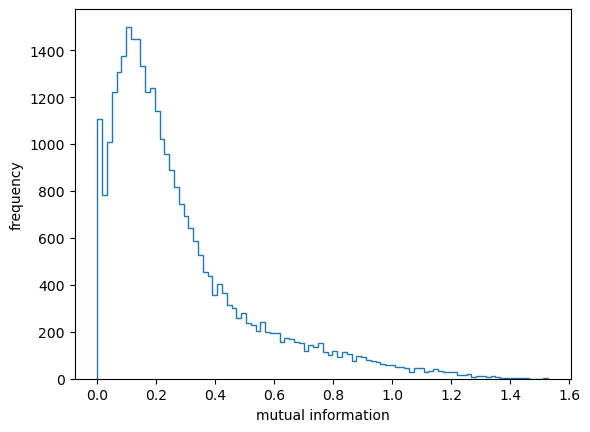

In [17]:
#plot histogram of mutual informations
fig=plt.figure()
plt.hist(mutual_info,bins='auto',histtype='step')
plt.xlabel('mutual information')
plt.ylabel('frequency')
plt.show()

Find the null distribution of mutual information by calculating the covariances with cyclically shifted signals:

In [18]:
n_shifts=1 #number of shifts to construct the null distribution
shifts=(len(brain_times_notnan)*np.sqrt(2)*(np.arange(n_shifts)+1)).astype(int)

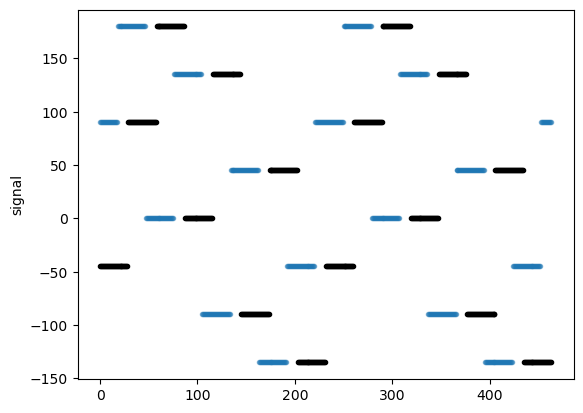

In [19]:
#plot histogram of correlations with shifted signals
fig=plt.figure()
plt.plot(signal_notnan,'k.')
for shift in shifts:
    plt.plot(np.roll(signal_notnan,shift),'.',alpha=0.5)
plt.ylabel('signal')
plt.show()

In [20]:
%%time
mutual_info_shifted=[]
for shift in shifts:
    X=np.roll(signal_notnan,shift).reshape(-1,1) #shift the signal in time
    for i in range(len(brain_fluorescence)):
        mutual_info_shifted.append(mutual_info_regression(X,brain_fluorescence_notnan[i],n_neighbors=n_neighbors,discrete_features=False,random_state=42)) #calculate the covariance
mutual_info_shifted=np.array(mutual_info_shifted).reshape(-1)

CPU times: user 2min 37s, sys: 212 ms, total: 2min 37s
Wall time: 2min 37s


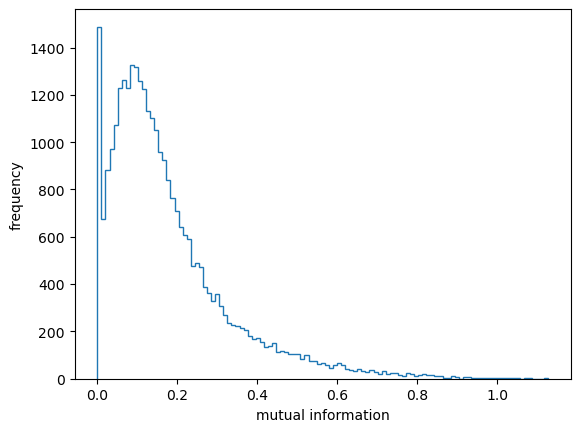

In [21]:
#plot histogram of covariance with shifted signals
fig=plt.figure()
plt.hist(mutual_info_shifted,bins='auto',histtype='step')
plt.xlabel('mutual information')
plt.ylabel('frequency')
plt.show()

In [22]:
#calculate p-values
x=-np.sort(-np.array(mutual_info_shifted))
y=np.arange(len(x))/len(x)
f_pvalue=interp1d(x,y,kind='previous',fill_value='extrapolate')
pvalue=np.zeros(len(brain_fluorescence))
for n in range(len(brain_fluorescence)):
    pvalue[n]=f_pvalue(mutual_info[n])

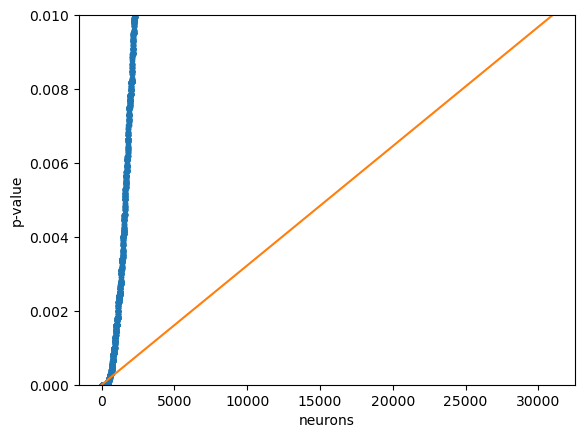

In [23]:
fdr=0.01#false discovery rate
fig=plt.figure()
plt.plot(np.sort(pvalue),'.') #ordered p-values
plt.plot((np.arange(len(pvalue))+1)/len(pvalue)*fdr) #benjamini-hochberg line
plt.ylim(0,fdr)
plt.xlabel('neurons')
plt.ylabel('p-value')
plt.show()

Number of neurons whose activity has a higher-than-chance covariance with the tail deflection amplitude:

In [25]:
#number of significantly correlated neurons according to the benjamini-hochberg procedure:
if len(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])==0:
    n_rejected_neurons=0
else:
    n_rejected_neurons=np.max(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])+1
n_rejected_neurons

522

In [26]:
indices=np.argsort(-mutual_info) #indices of all neurons sorted with decreasing correlation
indices_thr=indices[:n_rejected_neurons] #indices of significantly correlated neurons
characteristic=np.zeros(len(brain_fluorescence))
characteristic[indices_thr]=1 #it returns 1 on significantly correlated neurons

In [27]:
#fluorescence traces ordered with decreasing covariance
def f(neuron):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    ax.plot(brain_times,center(signal),c='black')
    ax.plot(brain_times,brain_fluorescence[indices[neuron]],'g')
    ax.set_xlim(brain_times[0],brain_times[-1])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$\Delta F/F$')
    plt.show()
    
interact(f,neuron=IntSlider(value=0,min=0,max=len(brain_fluorescence)-1,step=1));

interactive(children=(IntSlider(value=0, description='neuron', max=30970), Output()), _dom_classes=('widget-in…

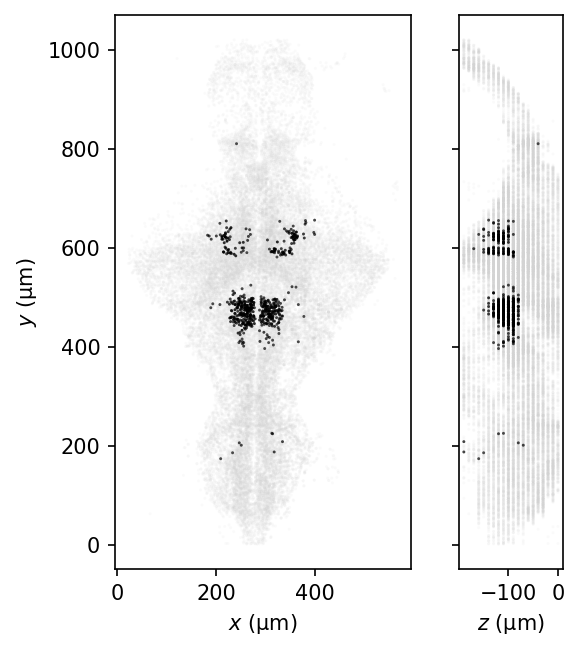

In [28]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=mutual_info/np.max(mutual_info)
alphas=opacity[mask]
s=2
c='k'

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax1.scatter(brain_coordinates[0,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (µm)')
ax1.set_ylabel('$y$ (µm)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax2.scatter(brain_coordinates[2,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (µm)')

plt.show()

In [29]:
#plots layer by layer
zs=np.unique(brain_coordinates[2])
zs=-np.sort(-zs) #ordered heights of the layers

mask=characteristic.astype(bool)
opacity=mutual_info/np.max(mutual_info)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=3
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    mask_l=(brain_coordinates[2]==zs[layer])&(mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5,edgecolors='none')
    xlayer=brain_coordinates[0,mask_l]
    ylayer=brain_coordinates[1,mask_l]
    alphas=opacity[(brain_coordinates[2]==zs[layer])&(mask)]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='black',alpha=alphas,edgecolors='none')

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (µm)')
    ax.set_ylabel('$y$ (µm)')
    plt.show()
    
interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

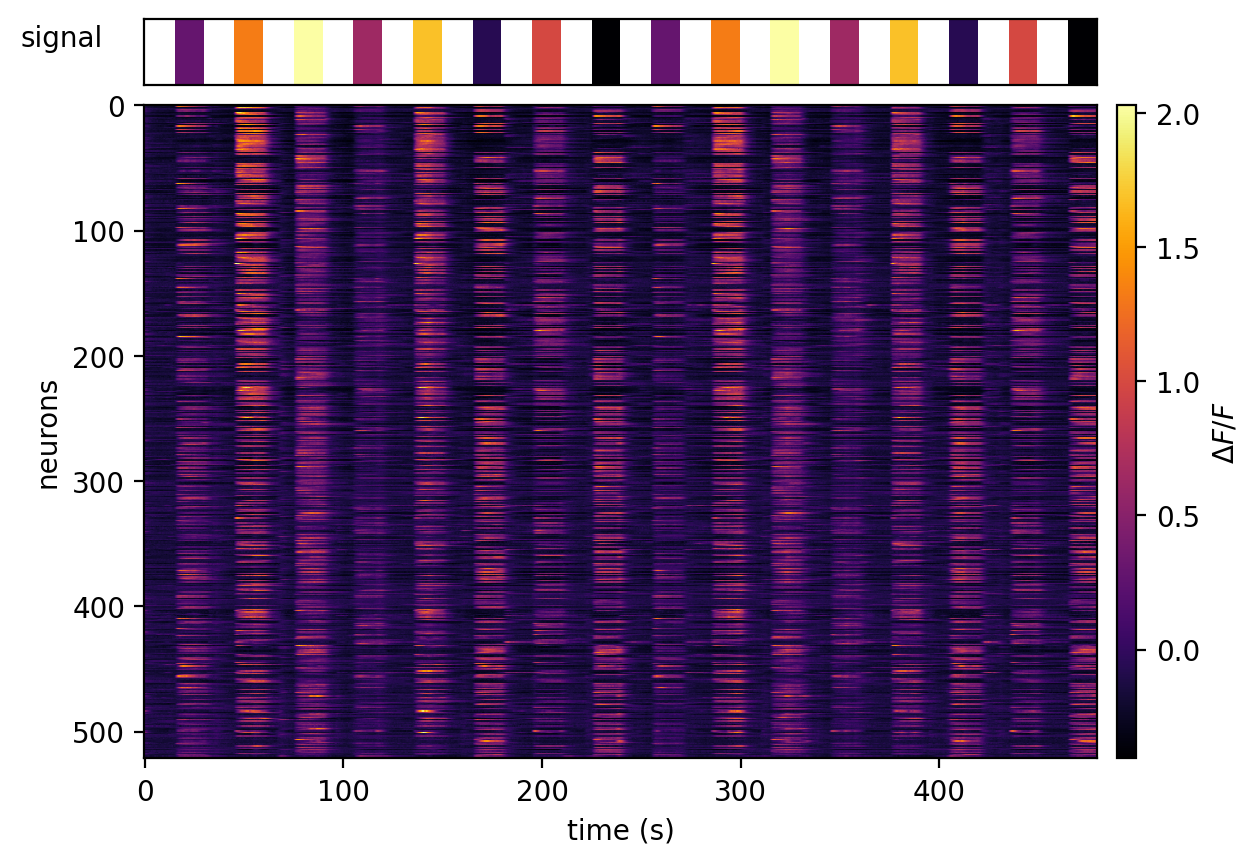

In [30]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=200)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[indices_thr][:,:],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()

Hierarchical clustering:

In [31]:
brain_fluorescence_subset=brain_fluorescence[indices_thr] #neurons whose fluorescence is significantly correlated with rest

In [32]:
np.shape(brain_fluorescence_subset)

(522, 960)

In [33]:
corrmat=np.corrcoef(brain_fluorescence_subset) #correlation matrix, using pearson correlation

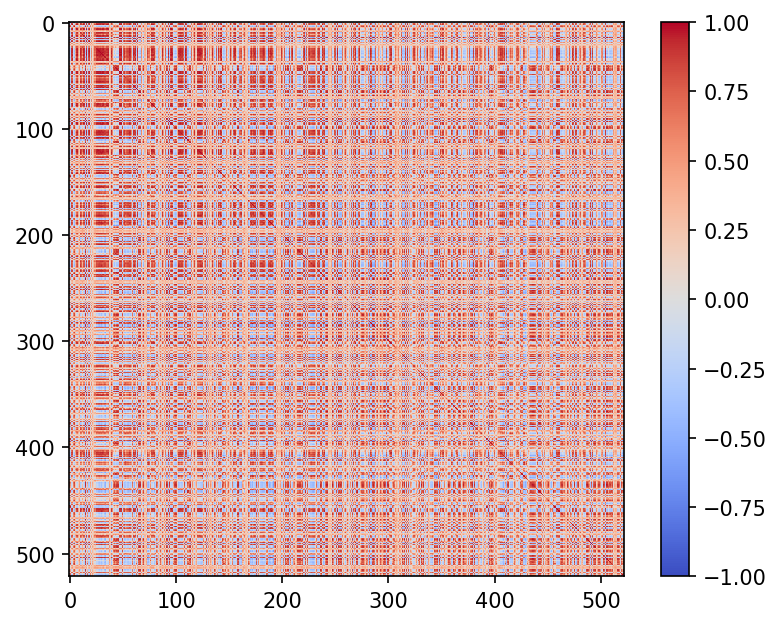

In [34]:
#display correlation matrix
fig=plt.figure(dpi=150)
plt.imshow(corrmat,cmap='coolwarm',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

In [37]:
distances=pdist(brain_fluorescence_subset,metric='correlation') #distance matrix as 1-(pearson correlation)
Z=sch.linkage(distances, 'ward') #hierarchical clustering with ward linkage
leaves=sch.leaves_list(Z)

In [38]:
threshold=7
#0.7*Z[-1,2] #threshold that defines the different clusters as a fraction of the distance between the two largest clusters
colors=['b','g','r','c','m','y','k','tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan','tab:gray']

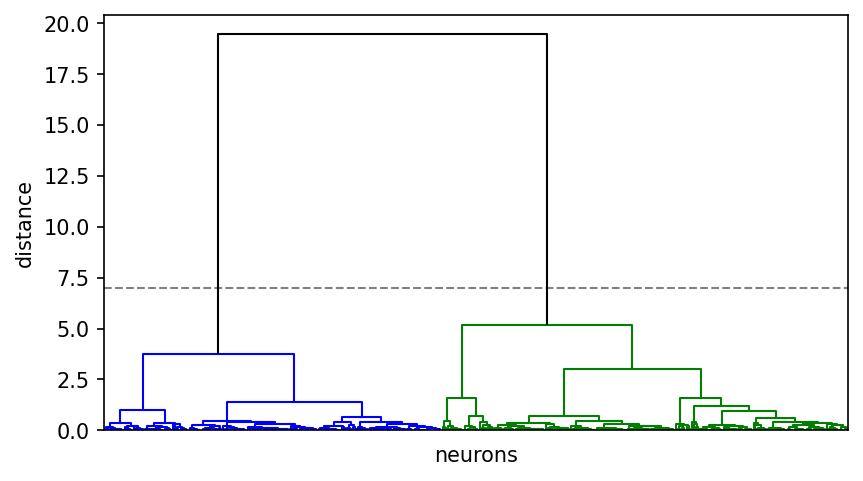

In [39]:
#display dendrogram with the various clusters
plt.rcParams['lines.linewidth']=1
fig=plt.figure(figsize=(6.4,0.75*4.8),dpi=150)
plt.axhline(threshold,c='gray',ls='--')
sch.set_link_color_palette(colors)
dn=sch.dendrogram(Z,color_threshold=threshold,above_threshold_color='black',no_labels=True)
plt.xlabel('neurons')
plt.ylabel('distance')
plt.show()
plt.rcParams['lines.linewidth']=1.5

In [40]:
clusters=sch.fcluster(Z,threshold,criterion='distance') #it returns a different label for each cluster

In [41]:
indices_clusters=[]
masks_clusters=[]
for n in np.unique(clusters).astype(int):
    indices_clusters.append(indices_thr[leaves[clusters[leaves]==n]]) #indices of the neurons in each cluster
    mask_n=np.zeros(len(brain_fluorescence))
    mask_n[indices_clusters[-1]]=1
    masks_clusters.append(mask_n.astype(bool)) #characteristic functions for the neurons in each cluster

In [42]:
len_clusters=[len(indices_clusters[n]) for n in range(len(indices_clusters))] #number of neurons in each cluster
len_clusters_sum=np.cumsum(len_clusters)

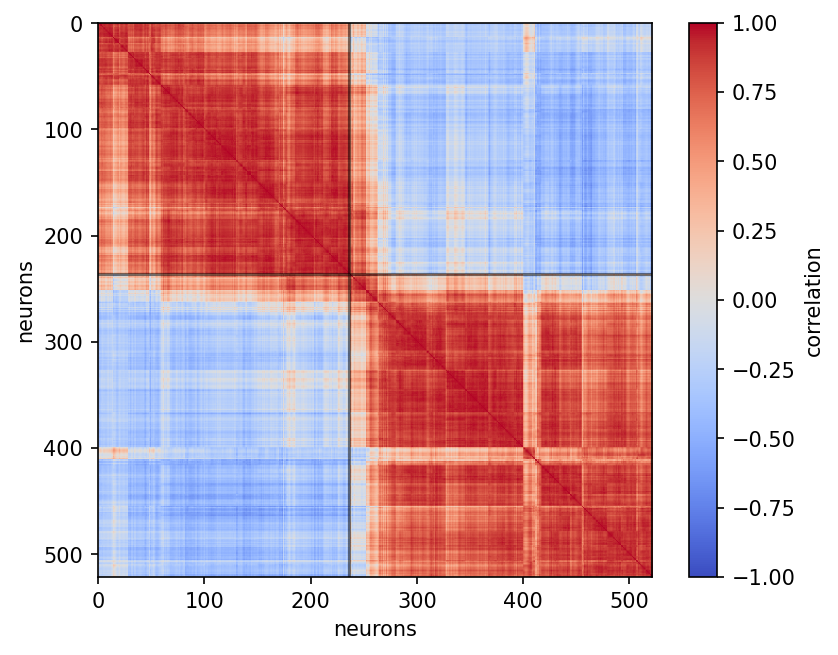

In [44]:
#plot correlation matrix with neurons sorted according to the clustering procedure and denote the various clusters
fig=plt.figure(dpi=150)
plt.imshow(corrmat[leaves,:][:,leaves],cmap='coolwarm',vmin=-1,vmax=1)
alpha=0.5
for n in range(len(indices_clusters)-1):
    plt.axhline(len_clusters_sum[n]-0.5,c='k',alpha=alpha)
    plt.axvline(len_clusters_sum[n]-0.5,c='k',alpha=alpha)
cbar=plt.colorbar()
cbar.set_label('correlation')
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.show()

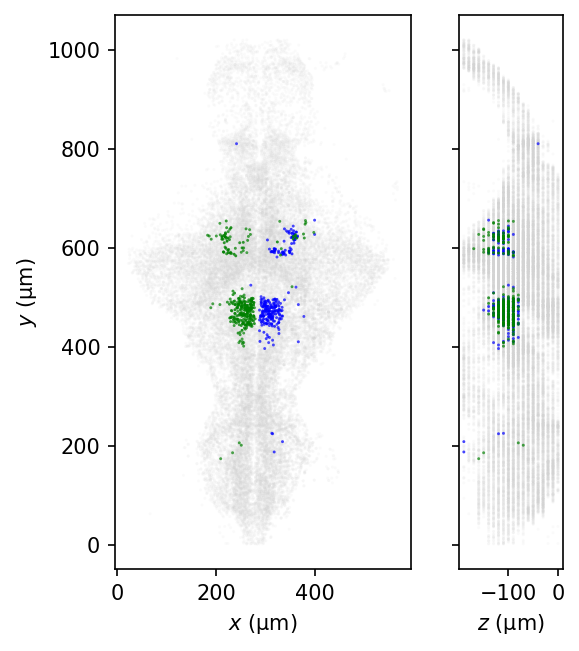

In [45]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=mutual_info/np.max(mutual_info)
s=2

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
for n,mask_cluster in enumerate(masks_clusters):
    alphas=opacity[mask_cluster]
    ax1.scatter(brain_coordinates[0,mask_cluster],brain_coordinates[1,mask_cluster],s=s,c=colors[n],alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (µm)')
ax1.set_ylabel('$y$ (µm)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
for n,mask_cluster in enumerate(masks_clusters):
    alphas=opacity[mask_cluster]
    ax2.scatter(brain_coordinates[2,mask_cluster],brain_coordinates[1,mask_cluster],s=s,c=colors[n],alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (µm)')

plt.show()

In [46]:
#plots layer by layer
mask=characteristic.astype(bool)
opacity=mutual_info/np.max(mutual_info)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=3
    
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5,edgecolors='none')
    for n,mask_cluster in enumerate(masks_clusters):
        mask_l=(brain_coordinates[2]==zs[layer])&(mask_cluster)
        xlayer=brain_coordinates[0,mask_l]
        ylayer=brain_coordinates[1,mask_l]
        alphas=opacity[mask_l]
        if len(xlayer)>0:
            ax.scatter(xlayer,ylayer,s=s,c=colors[n],alpha=alphas,edgecolors='none')

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (µm)')
    ax.set_ylabel('$y$ (µm)')
    plt.show()
    
interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

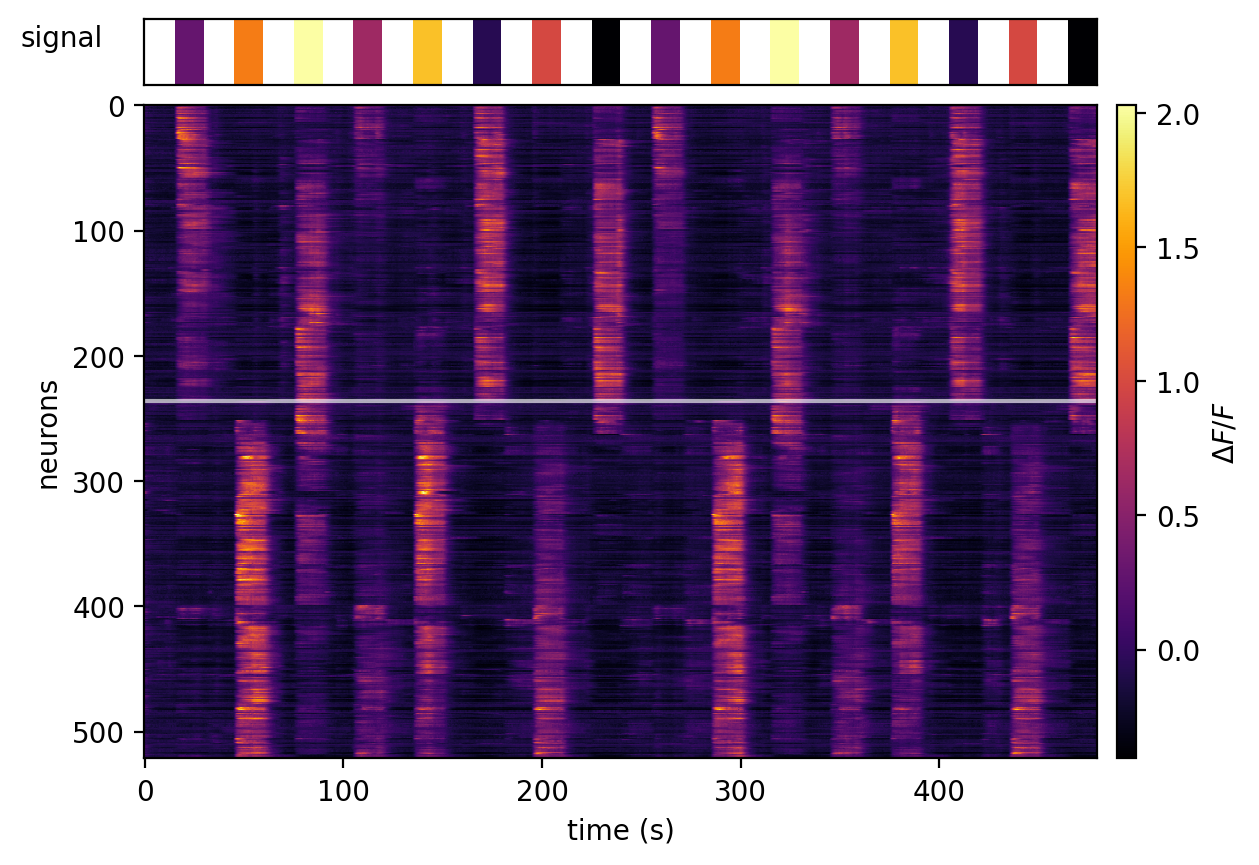

In [47]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=200)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[np.concatenate(indices_clusters)],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

for n in range(len(indices_clusters)-1):
    ax.axhline(len_clusters_sum[n]-0.5,c='w',alpha=0.66)

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()

Plot tuning curves:

In [48]:
#average dff in each cluster
average_fluorescence_clusters=[]
for n in range(len(indices_clusters)):
    average_fluorescence_clusters.append(np.mean(brain_fluorescence[indices_clusters[n]],axis=0))

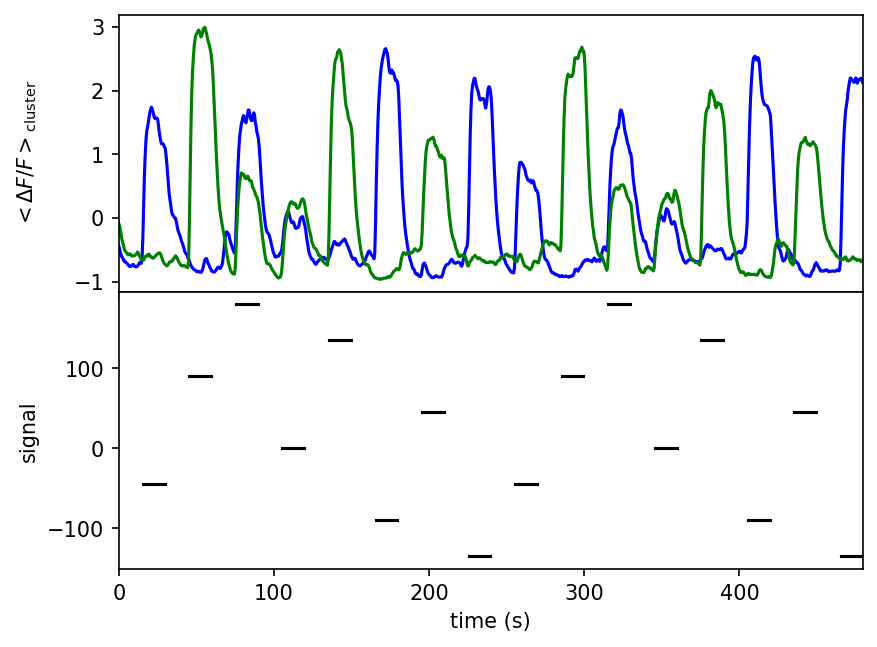

In [49]:
#plot average cluster fluorescence
t1=0
t2=brain_times[-1]

fig,(ax1,ax2)=plt.subplots(2,1,dpi=150,sharex=True)
plt.subplots_adjust(hspace=0)
for n in range(len(indices_clusters)):
    ax1.plot(brain_times,center(average_fluorescence_clusters[n]),c=colors[n])
#for i in range(len(args[0])):
#    ax1.plot(tt_c,dff_c[args[0][i]],alpha=0.5,c='b')
ax1.set_ylabel(r'$<\Delta F/F>_\mathrm{cluster}$')
ax2.set_ylabel('signal')
ax2.plot(brain_times,signal,'k')
ax2.set_xlim(t1,t2)
ax2.set_xlabel('time (s)')
fig.align_ylabels((ax1,ax2))

plt.show()

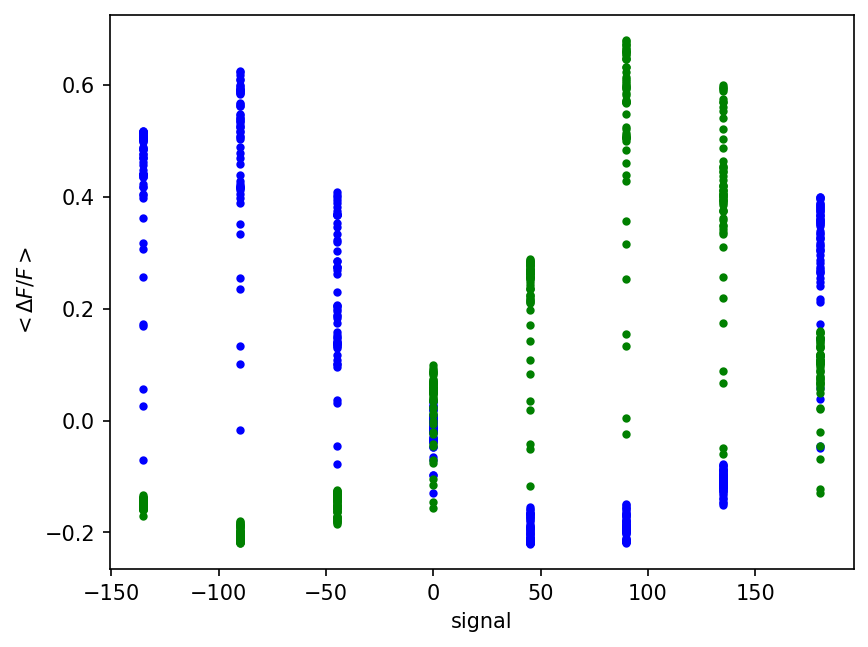

In [50]:
fig,ax=plt.subplots(dpi=150)
for n in range(len(indices_clusters)):
    ax.plot(signal,average_fluorescence_clusters[n],'.',c=colors[n])
ax.set_ylabel(r'$<\Delta F/F>$')
ax.set_xlabel('signal')
plt.show()

In [51]:
bins=8
bin_edges=np.histogram_bin_edges(signal_notnan,bins,range=(-135-45/2,180+45/2))

In [52]:
tuning_curves=np.zeros((len(indices_clusters),bins))
for i in range(bins):
    for n in range(len(indices_clusters)):
        tuning_curves[n,i]=np.nanmean(average_fluorescence_clusters[n][(signal>bin_edges[i])&(signal<bin_edges[i+1])])

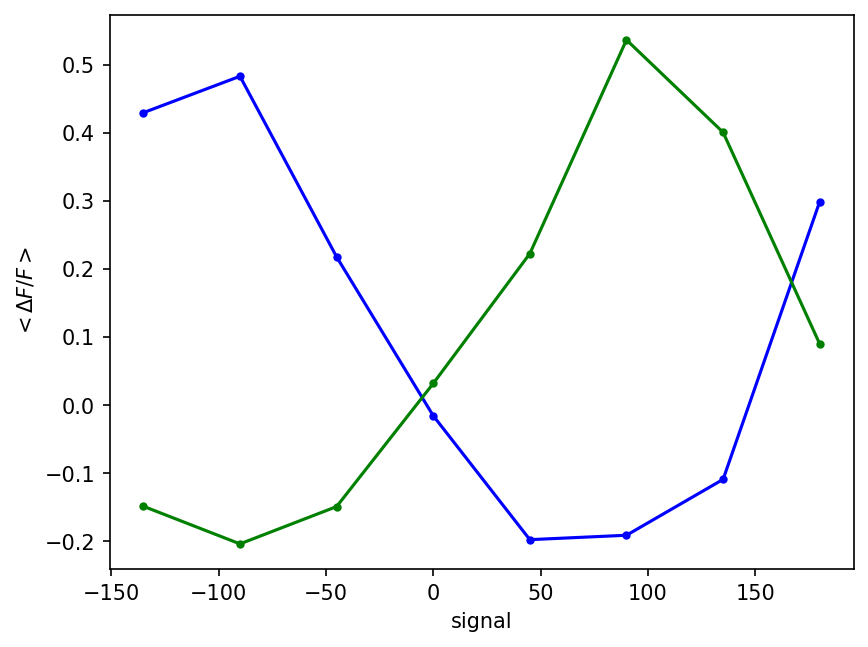

In [53]:
fig,ax=plt.subplots(dpi=150)
for n in range(len(indices_clusters)):
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,tuning_curves[n],'.-',c=colors[n])
ax.set_ylabel(r'$<\Delta F/F>$')
ax.set_xlabel('signal')
plt.show()